# Kaggle: Facial Keypoints Detection

## Introduction
Goal: Predict keypoint positions on face images.

In [1]:
import pandas as pd
import numpy as np

In [2]:
IMAGE_SIZE = 96

In [3]:
# ???
def load_training_data():
    df = pd.read_csv('data/training.csv')
    
    keypoint_cols = df.columns[:-1]
    
    # Change image column into a numpy array
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' ') / 255.0)
    
    # For now, delete rows with empty data
    df.dropna(inplace=True)
    
    # vstack: Take a sequence of arrays and stack them vertically to make a single array.
    X = np.vstack(df['Image'])                     # .astype(np.float) ?
    
    # 
    X = X.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 1)
    
    y = df[keypoint_cols].values / 96.0
    
    #X, y = shuffle(X, y)
    #joblib.dump(keypoint_cols, 'data/cols.pkl', compress=3)

    return X, y


In [5]:
# X, y = load_training_data()

In [6]:
df = pd.read_csv('data/training.csv')
# Change image column into a numpy array
df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))


In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

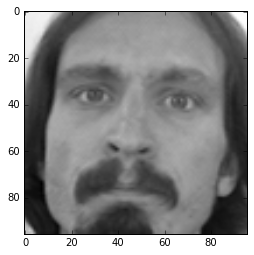

In [8]:
imgplot = plt.imshow(df.Image[0].reshape(96, 96), cmap='gray')

In [9]:
# For now, delete rows with empty data
df.dropna(inplace=True)

In [10]:
df.shape

(2140, 31)

In [11]:
X = np.vstack(df.Image)

In [12]:
X[0]

array([ 238.,  236.,  237., ...,   70.,   75.,   90.])

In [13]:
y = df.drop('Image', axis=1).values

In [14]:
y[0]

array([ 66.03356391,  39.00227368,  30.22700752,  36.4216782 ,
        59.58207519,  39.64742256,  73.13034586,  39.96999699,
        36.35657143,  37.3894015 ,  23.45287218,  37.3894015 ,
        56.95326316,  29.03364812,  80.22712782,  32.22813835,
        40.22760902,  29.0023218 ,  16.35637895,  29.64747068,
        44.42057143,  57.06680301,  61.19530827,  79.97016541,
        28.61449624,  77.38899248,  43.3126015 ,  72.93545865,
        43.13070677,  84.48577444])

## PCA

In [26]:
n_features = X.shape[1]
n_features

9216

In [15]:
# split into a training and testing set
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

# will use x_test as sample OOS data

In [16]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score

from sklearn import decomposition
from sklearn.pipeline import Pipeline


In [17]:
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
h, w = 96, 96
n_components = 150

print("Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0]))
pca = decomposition.PCA(n_components=n_components, whiten=True).fit(X_train)

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)


Extracting the top 150 eigenfaces from 1605 faces
Projecting the input data on the eigenfaces orthonormal basis


In [18]:
from sklearn.neighbors import KNeighborsRegressor

In [19]:
pca = decomposition.PCA(n_components=150, whiten=True)
knn = KNeighborsRegressor(5)
pipe = Pipeline(steps=[('pca', pca), ('knn', knn)])


In [20]:
cv = cross_val_score(pipe, X, y)

In [21]:
cv

array([ 0.46091675,  0.28126632, -0.30835552])

In [22]:
pipe.fit(X, y)

Pipeline(steps=[('pca', PCA(copy=True, n_components=150, whiten=True)), ('knn', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform'))])

In [23]:
y_pred = pipe.predict(X_test)

In [24]:
from sklearn import metrics
print np.sqrt(abs(metrics.mean_squared_error(y_test, y_pred)))



2.0719384957


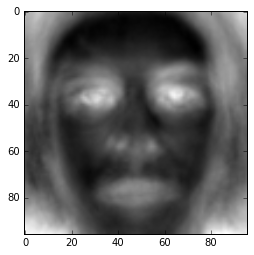

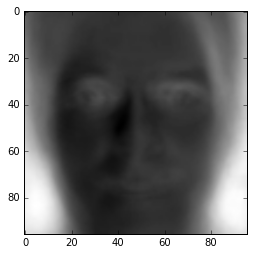

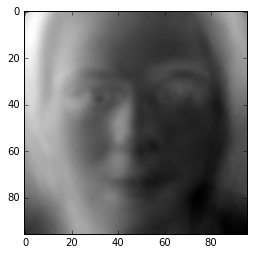

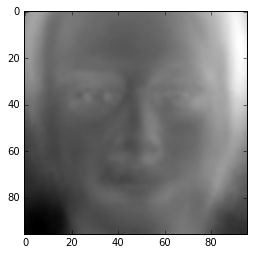

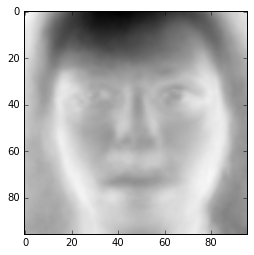

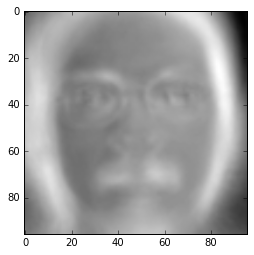

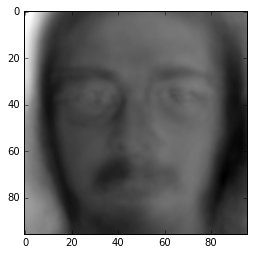

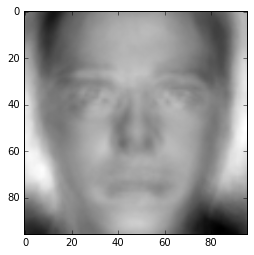

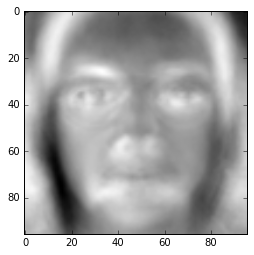

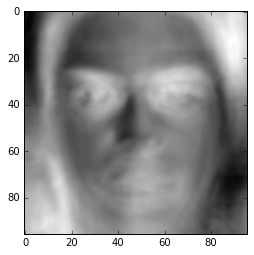

In [25]:
for i in range(10):
    plt.imshow(eigenfaces[i].reshape((h, w)), cmap=plt.cm.gray)
    plt.show()

In [26]:
# search for an optimal value of K
k_range = range(1, 30, 2)
scores = []
for k in k_range:
    knn = KNeighborsRegressor(n_neighbors=k)
    pipe = Pipeline(steps=[('pca', pca), ('knn', knn)])
    scores.append(cross_val_score(pipe, X, y, cv=5, scoring='mean_squared_error'))
scores


[array([ -3.43253148,  -3.48746053,  -5.43980225, -15.76265454, -21.13095245]),
 array([ -2.84257275,  -2.78584625,  -4.56465753, -13.09931195, -19.0986678 ]),
 array([ -2.93344877,  -2.77829239,  -4.6254492 , -12.79628359, -19.00360937]),
 array([ -3.21491278,  -2.92121632,  -4.73027815, -12.78114912, -19.03627974]),
 array([ -3.44712218,  -3.10523006,  -4.87084641, -12.83339241, -19.040698  ]),
 array([ -3.63181014,  -3.27695368,  -4.98504448, -12.76278679, -19.1282648 ]),
 array([ -3.85194333,  -3.45620327,  -5.16639179, -12.7644412 , -19.06870696]),
 array([ -4.04491535,  -3.66137797,  -5.29540289, -12.83832129, -19.07284454]),
 array([ -4.17889173,  -3.89442772,  -5.44033111, -12.89189159, -19.02687794]),
 array([ -4.36327663,  -4.10555697,  -5.62050486, -12.89738491, -18.97277955]),
 array([ -4.53752964,  -4.26894324,  -5.73382022, -12.88009239, -18.96247017]),
 array([ -4.6773632 ,  -4.39855646,  -5.81037244, -12.81133686, -18.92868926]),
 array([ -4.79418787,  -4.56031287,  -5.

In [28]:
rmse_list = []
for i in range(len(scores)):
    rmse_list.append(np.sqrt(abs(scores[i])).mean())
rmse_list

[2.9239169015129747,
 2.6962167790348115,
 2.6933480926411564,
 2.723045298718314,
 2.7543491426127931,
 2.7789558887715224,
 2.8068404393553488,
 2.8352303200511271,
 2.860524992554526,
 2.8865783840429735,
 2.9068611978531642,
 2.92009407606144,
 2.9337624600177996,
 2.9409582697126089,
 2.9503321690158364]

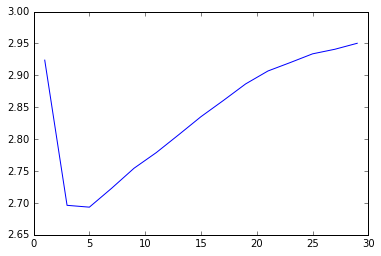

In [29]:
# That took a long time to run.
# plot the K values (x-axis) versus the 5-fold CV score (y-axis)
plt.figure()
plt.plot(k_range, rmse_list)

In [31]:
# automatic grid search for an optimal value of K
from sklearn.grid_search import GridSearchCV
knn = KNeighborsRegressor()
#pipe = Pipeline(steps=[('pca', pca), ('knn', knn)])

k_range = range(1, 100, 10)
param_grid = dict(n_neighbors=k_range)
grid = GridSearchCV(knn, param_grid, cv=5, scoring='mean_squared_error')
grid.fit(X, y)

GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [1, 11, 21, 31, 41, 51, 61, 71, 81, 91]},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_squared_error',
       verbose=0)

In [32]:
grid.best_score_  

-7.1010465230005515

In [33]:
grid.best_params_

{'n_neighbors': 11}

In [34]:
grid.best_estimator_

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=11, p=2,
          weights='uniform')

In [36]:
np.sqrt(abs(grid.best_score_))

2.6647788882007735

In [ ]:
# import tensorflow as tf

## saber1988's Solution
This network contains 2 convolutional layers and 2 fully connected layers, and the output layer is linear. Each convolutional layer is followed by a max-pooling layer, and use relu as activation function.

---
### `tf.nn.conv2d(input, filter, strides, padding, use_cudnn_on_gpu=None, data_format=None, name=None)`

Computes a 2-D convolution given 4-D input and filter tensors.

Given an input tensor of shape [batch, in_height, in_width, in_channels] and a filter / kernel tensor of shape [filter_height, filter_width, in_channels, out_channels], this op performs the following:

1. Flattens the filter to a 2-D matrix with shape `[filter_height * filter_width * in_channels, output_channels]`.
2. Extracts image patches from the input tensor to form a virtual tensor of shape `[batch, out_height, out_width, filter_height * filter_width * in_channels]`.
3. For each patch, right-multiplies the filter matrix and the image patch vector.

In detail, with the default NHWC format,

`output[b, i, j, k] =`
    `sum_{di, dj, q} input[b, strides[1] * i + di, strides[2] * j + dj, q] *
                    filter[di, dj, q, k]`

Must have `strides[0] = strides[3] = 1`. For the most common case of the same horizontal and vertices strides, `strides = [1, stride, stride, 1]`.

Args:

* `input`: A Tensor. Must be one of the following types: `half, float32, float64`.
* `filter`: A Tensor. Must have the same type as input.
* strides: A list of ints. 1-D of length 4. The stride of the sliding window for each dimension of input. Must be in the same order as the dimension specified with format.
* `padding`: A string from: `"SAME", "VALID"`. The type of padding algorithm to use.
* `use_cudnn_on_gpu`: An optional bool. Defaults to True.
* `data_forma`t: An optional string from: `"NHWC", "NCHW"`. Defaults to `"NHWC"`. Specify the data format of the input and output data. With the default format "NHWC", the data is stored in the order of: `[batch, in_height, in_width, in_channels]`. Alternatively, the format could be `"NCHW"`, the data storage order of: `[batch, in_channels, in_height, in_width]`.
* `name`: A name for the operation (optional).

Returns:

A Tensor. Has the same type as input.

---

---
### `tf.nn.max_pool(value, ksize, strides, padding, data_format='NHWC', name=None)`

Performs the max pooling on the input.

Args:

* value: A 4-D Tensor with shape [batch, height, width, channels] and type tf.float32.
* ksize: A list of ints that has length >= 4. The size of the window for each dimension of the input tensor.
* strides: A list of ints that has length >= 4. The stride of the sliding window for each dimension of the input tensor.
* padding: A string, either 'VALID' or 'SAME'. The padding algorithm. See the comment here
* data_format: A string. 'NHWC' and 'NCHW' are supported.
* name: Optional name for the operation.

Returns:

A Tensor with type tf.float32. The max pooled output tensor.

---

## TensorFlow tutorial, Build a Multilayer Convolutional Network

https://www.tensorflow.org/versions/r0.10/tutorials/mnist/pros/index.html

Modify for Facial Keypoints Detection

Also see MNIST For ML Beginners tutorial
https://www.tensorflow.org/versions/r0.10/tutorials/mnist/beginners/index.html

>Flattening the data throws away information about the 2D structure of the image. Isn't that bad? Well, the best computer vision methods do exploit this structure, and we will in later tutorials. But the simple method we will be using here, a softmax regression (defined below), won't.

>The result is that mnist.train.images is a tensor (an n-dimensional array) with a shape of [55000, 784]. The first dimension is an index into the list of images and the second dimension is the index for each pixel in each image. East entry in the tensor is a pixel intensity between 0 and 1, for a particular pixel in a particular image.

## Weight Initialization

To create this model, we're going to need to create a lot of weights and biases. One should generally initialize weights with a small amount of noise for symmetry breaking, and to prevent 0 gradients. Since we're using ReLU neurons, it is also good practice to initialize them with a slightly positive initial bias to avoid "dead neurons". Instead of doing this repeatedly while we build the model, let's create two handy functions to do it for us.

In [37]:
#Break these functions down

In [ ]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

## Convolution and Pooling

TensorFlow also gives us a lot of flexibility in convolution and pooling operations. How do we handle the boundaries? What is our stride size? In this example, we're always going to choose the vanilla version. Our convolutions uses a stride of one and are zero padded so that the output is the same size as the input. Our pooling is plain old max pooling over 2x2 blocks. To keep our code cleaner, let's also abstract those operations into functions.

In [ ]:
def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')

**Deadpool:** When was I ever part of a solution?

## First Convolutional Layer

We can now implement our first layer. It will consist of convolution, followed by max pooling. The convolutional will compute 32 features for each 5x5 patch. Its weight tensor will have a shape of [5, 5, 1, 32]. The first two dimensions are the patch size, the next is the number of input channels, and the last is the number of output channels. We will also have a bias vector with a component for each output channel.

In [ ]:
# W_conv1 = weight_variable([5, 5, 1, 32])
# Change to:
W_conv1 = weight_variable([3, 3, 1, 32])
b_conv1 = bias_variable([32])


In [ ]:
#From saber1988
# h_conv1 = skflow.ops.conv2d(X, n_filters=32, filter_shape=[3, 3],
#                                    bias=True, activation=tf.nn.relu)

To apply the layer, we first reshape x to a 4d tensor, with the second and third dimensions corresponding to image width and height, and the final dimension corresponding to the number of color channels.

In [ ]:
# x_image = tf.reshape(x, [-1,28,28,1])
# Change to:
x_image = tf.reshape(x, [-1,96,96,1])    # Leave final dimension as 1?

We then convolve x_image with the weight tensor, add the bias, apply the ReLU function, and finally max pool.

In [ ]:
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

## Second Convolutional Layer

In order to build a deep network, we stack several layers of this type. The second layer will have 64 features for each 5x5 patch.

In [ ]:
# W_conv2 = weight_variable([5, 5, 32, 64])
# From saber1988: second conv layer will compute 64 features for each 2x2 patch
W_conv2 = weight_variable([2, 2, 32, 64])  #What is the 32? Inputs from upstream layer
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

## Third Convolutional Layer

Do I want to add a third layer?

Let's examine how we are getting a 7x7 image.
max pooling over 2x2 blocks

Starting with 28x28

Here we are using:<br>
`tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')`

2x2 input<br>
stride 2, 2

See max_pool.graffle 

Yep, 7x7

1. zero-padding the 28x28x1 image to 32x32x1
2. applying 5x5x32 convolution to get 28x28x32
3. max-pooling down to 14x14x32
4. zero-padding the 14x14x32 to 18x18x32
5. applying 5x5x32x64 convolution to get 14x14x64
6. max-pooling down to 7x7x64.


## Densely Connected Layer

Now that the image size has been reduced to 7x7, we add a fully-connected layer with 1024 neurons to allow processing on the entire image. We reshape the tensor from the pooling layer into a batch of vectors, multiply by a weight matrix, add a bias, and apply a ReLU.

In [ ]:
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

Why 1024 neurons? 

#### Dropout

To reduce overfitting, we will apply dropout before the readout layer. We create a placeholder for the probability that a neuron's output is kept during dropout. This allows us to turn dropout on during training, and turn it off during testing. TensorFlow's tf.nn.dropout op automatically handles scaling neuron outputs in addition to masking them, so dropout just works without any additional scaling.

In [ ]:
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

## Readout Layer

Finally, we add a softmax layer, just like for the one layer softmax regression above.

In [ ]:
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv=tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

My readout layer will be different. 30 outputs. Linear regression.

old: return skflow.models.linear_regression(h_fc1, y)

old: What is this in tensorflow?

m = tf.contrib.learn.LinearClassifier(feature_columns=h_fc1_drop, model_dir=model_dir)

## Train and Evaluate the Model

How well does this model do? To train and evaluate it we will use code that is nearly identical to that for the simple one layer SoftMax network above.

The differences are that:

* We will replace the steepest gradient descent optimizer with the more sophisticated ADAM optimizer.

* We will include the additional parameter keep_prob in feed_dict to control the dropout rate.

* We will add logging to every 100th iteration in the training process.

Feel free to go ahead and run this code, but it does 20,000 training iterations and may take a while (possibly up to half an hour), depending on your processor.

In [ ]:
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y_conv), reduction_indices=[1]))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
sess.run(tf.initialize_all_variables())
for i in range(20000):
  batch = mnist.train.next_batch(50)
  if i%100 == 0:
    train_accuracy = accuracy.eval(feed_dict={
        x:batch[0], y_: batch[1], keep_prob: 1.0})
    print("step %d, training accuracy %g"%(i, train_accuracy))
  train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

print("test accuracy %g"%accuracy.eval(feed_dict={
    x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

The final test set accuracy after running this code should be approximately 99.2%.

We have learned how to quickly and easily build, train, and evaluate a fairly sophisticated deep learning model using TensorFlow.

(End of tutorial)